In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
from sklearn.base import clone

# access utilities
import joblib

import sys
from pathlib import Path

# Adjust the system path to include the project root directory. 
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

# Import the project configuration settings.
import config
from config import RANDOM_SEED
config.set_seed()

# Import the DataPreprocessingPipeline class from 'utils' in 'scripts/preprocessing'.
from utils import DataPreprocessingPipeline

In [2]:

# Use the load_data function from config to load .sas7bdat file
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

In [3]:
target = 'WAITTIME_BINARY'
target_to_drop = ['WAITTIME','LOV_BINARY']

In [4]:
# Instantiate the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df,target=target,target_to_drop=target_to_drop,percent_train=0.70,percent_val=0.15,percent_test=0.15,stratify=True)

# Run the pipeline
pipeline.run()

X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test

y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
print("Length y_test",len(y_test))

X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed

feature_names = pipeline.feature_names

emergency_df = pipeline.emergency_df 
cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

print("Count number of rows per classes of", cleaned_emergency_df[target].value_counts())

preprocessor = pipeline.processor

# Ensure feature_names is treated as a list
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(19197, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(19197, 387)

3-Splitting data...
self.stratify: True
Splitting data completed

4-Loading data...
train_df size: (13437, 387)
X_train size: (13437, 386)
y_train size: (13437,)

validation_df size: (2879, 387)
X_validation size: (2879, 386)
y_validation size: (2879,)

test_df size: (2881, 387)
X_test size: (2881, 386)
y_test size: (2881,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully
Length y_test 2881
Count number of rows per classes of WAITTIME_BINARY
0.0    11840
1.0     7357
Name: count, dtype: int64


In [5]:

# Define the models and their default parameters correctly wrapped in a dictionary under 'model'
models_defaults = {
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_SEED, verbose=0),
    'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_SEED, silent=True),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_SEED),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(random_state=RANDOM_SEED)
}

# Define scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

# Create a Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model_scores = {}
best_model_name = None
best_model = None
best_f1 = 0  # Initial low F1 score

# Loop over each model and evaluate their performance using cross-validation
for model_name in models_defaults:
    model = models_defaults[model_name]
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('resampling', SMOTE(random_state=RANDOM_SEED)), ('classifier', model)])
    
    # Perform cross-validation
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1)
    
    # Calculate the average of the cross-validation scores
    mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring_metrics}
    model_scores[model_name] = mean_scores

    # Determine if this model is the best model
    if mean_scores['f1_weighted'] > best_f1:
        best_model_name = model_name
        best_model = model # Cloning the model to store its state
        best_f1 = mean_scores['f1_weighted']

# After scoring all models, create a DataFrame to store results
results = []
for model_name, scores in model_scores.items():
    results.append({
        'Model Name': model_name,
        'Precision': scores['precision'],
        'Recall': scores['recall'],
        'F1 Weighted': scores['f1_weighted'],
        'ROC AUC': scores['roc_auc'],
        'Is Best Model': 'Yes' if model_name == best_model_name else 'No'
    })
best_model = CatBoostClassifier(random_state=42, silent=True)
# Create the DataFrame
result_df = pd.DataFrame(results)

# Select only numerical columns and round them to two decimal places
numerical_cols = result_df.select_dtypes(include=np.number).columns
result_df[numerical_cols] = result_df[numerical_cols].round(2)

print("Best Model Based on F1 Weighted Score:")
print(f"Model Name: {best_model_name}")

# Save the best model instance, not its name
model_filename = "best_waittime_classification_model.joblib"
# Adjusted to directly save the model instance
config.save_model(best_model, model_filename) 
print(f"{model_filename} saved")

# Display the DataFrame
result_df


Best Model Based on F1 Weighted Score:
Model Name: CatBoostClassifier
best_waittime_classification_model.joblib saved


,Model Name,Precision,Recall,F1 Weighted,ROC AUC,Is Best Model
0,LGBMClassifier,0.69,0.60,0.74,0.71,No
1,CatBoostClassifier,0.69,0.62,0.74,0.72,Yes
2,RandomForestClassifier,0.68,0.47,0.70,0.67,No
3,XGBClassifier,0.65,0.60,0.72,0.70,No
4,MLPClassifier,0.58,0.56,0.67,0.65,No


100%|===================| 13379/13437 [03:52<00:01]        

n: 10, Precision: 0.68, Recall: 0.56, F1: 0.72, ROC AUC: 0.70


100%|===================| 13433/13437 [03:53<00:00]        

n: 20, Precision: 0.70, Recall: 0.60, F1: 0.74, ROC AUC: 0.72


100%|===================| 13383/13437 [03:52<00:00]        

n: 50, Precision: 0.69, Recall: 0.59, F1: 0.74, ROC AUC: 0.71


100%|===================| 13426/13437 [03:54<00:00]        

n: 60, Precision: 0.70, Recall: 0.59, F1: 0.74, ROC AUC: 0.71

Best Model Configuration:
Best n: 20
F1 Score: 0.74, ROC AUC: 0.72


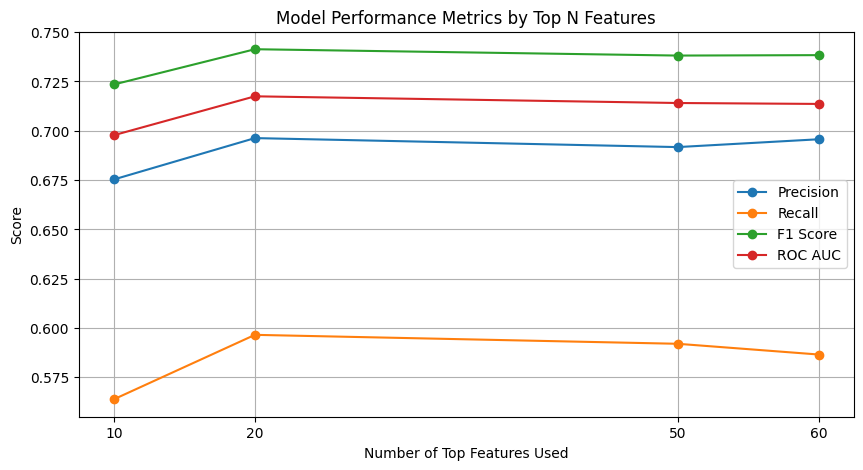

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Define the best model directly as specified
best_model = CatBoostClassifier(random_state=RANDOM_SEED, verbose=0)
best_n =  None
top_features = None
# Define a function to calculate SHAP values and return feature importances
def get_shap_importance(model, X_train):
    """Calculate SHAP values and return sorted feature importances."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer.shap_values(X_train)
    shap_importances = np.abs(shap_values).mean(axis=0)
    return shap_importances

# Define a function to fit a model using selected features and evaluate it
def evaluate_model_with_shap(model, X_train, y_train, X_validation, y_validation, feature_names, n):
    """Fit model, evaluate it, and return evaluation metrics and sorted features by importance."""
    model.fit(X_train, y_train)
    shap_importances = get_shap_importance(model, X_train)
    indices = np.argsort(shap_importances)[::-1][
        :n
    ]  # Get indices of the top n important features
    selected_feature_names = np.array(feature_names)[
        indices
    ]  # Sort feature names by importance

    X_train_n = X_train[:, indices]
    X_validation_n = X_validation[:, indices]

    model.fit(X_train_n, y_train)  # Refit model on selected features
    y_pred = model.predict(X_validation_n)
    precision = precision_score(y_validation, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_validation, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_validation, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_validation, y_pred)

    return precision, recall, f1, roc_auc, selected_feature_names

n_list = [10, 20, 50, 60]
feature_names = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
]

precision_list, recall_list, f1_list, roc_auc_list,features_list = [], [], [], [], []

# Evaluate model for different values of n
for n in n_list:
    model = clone(best_model)  # Reset the model
    precision, recall, f1, roc_auc, selected_features = evaluate_model_with_shap(
         model, X_train_preprocessed, y_train, X_validation_preprocessed, y_validation, feature_names, n)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    features_list.append(selected_features) 

    print(f"n: {n}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

# Print the best configuration based on F1 score
best_index = np.argmax(f1_list)
best_n = n_list[best_index] 
top_features =  features_list[best_index] 
print(f"\nBest Model Configuration:")
print(f"Best n: {n_list[best_index]}")
print(f"F1 Score: {f1_list[best_index]:.2f}, ROC AUC: {roc_auc_list[best_index]:.2f}")


# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(n_list, precision_list, label='Precision', marker='o')
plt.plot(n_list, recall_list, label='Recall', marker='o')
plt.plot(n_list, f1_list, label='F1 Score', marker='o')
plt.plot(n_list, roc_auc_list, label='ROC AUC', marker='o')
plt.title('Model Performance Metrics by Top N Features')
plt.xlabel('Number of Top Features Used')
plt.ylabel('Score')
plt.xticks(n_list)
plt.legend()
plt.grid(True)
plt.show()


100%|===================| 13389/13437 [03:53<00:00]        

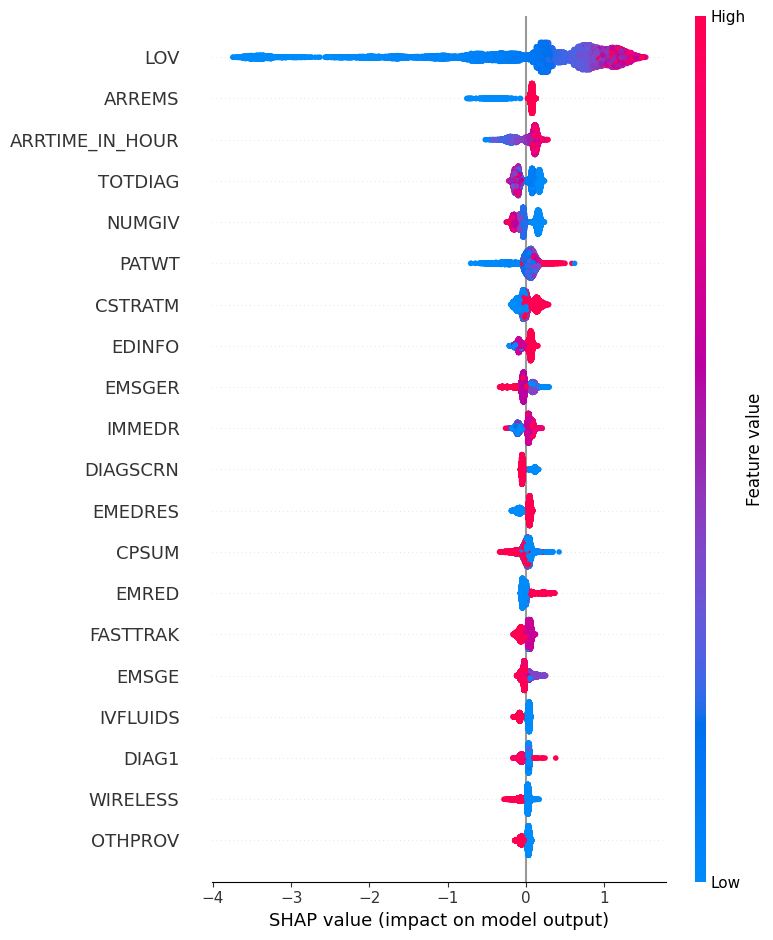

Top N Features (Cleaned Names): ['LOV' 'ARREMS' 'ARRTIME_IN_HOUR' 'TOTDIAG' 'NUMGIV' 'PATWT' 'CSTRATM'
 'EDINFO' 'EMSGER' 'IMMEDR' 'DIAGSCRN' 'EMEDRES' 'CPSUM' 'EMRED'
 'FASTTRAK' 'EMSGE' 'IVFLUIDS' 'DIAG1' 'WIRELESS' 'OTHPROV']


In [7]:

model = clone(best_model)
model.fit(X_train_preprocessed, y_train)  # Ensure model is fitted

def plot_shap_summary(model, X_train_preprocessed, feature_names, n):
    """
    Plots SHAP summary plot of the top N features.

    Parameters:
    - model: The trained model.
    - X_train_preprocessed: The preprocessed training data.
    - feature_names: Names of the features after preprocessing.
    - n: Number of top features to consider.
    """
    # Initialize the SHAP Tree explainer and compute SHAP values
    explainer = shap.Explainer(model, X_train_preprocessed)
    shap_values = explainer.shap_values(X_train_preprocessed)

    # Plot the SHAP summary plot for the top N features
    shap.summary_plot(
        shap_values,
        X_train_preprocessed,
        feature_names=feature_names,
        max_display=n,
        show=True,
    )


# Extract top N features based on the earlier best_features selection
n = best_n  # This is set from the previous analysis
feature_names_list = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
] 

# Call the function to plot SHAP values for the top N feature names
plot_shap_summary(
    model=model,
    X_train_preprocessed=X_train_preprocessed,
    feature_names=feature_names_list,
    n=n,
)

# After plotting, continue with any additional processing or saving
print("Top N Features (Cleaned Names):", top_features)

# Extracting indices of top features directly since prefixes have been removed
top_feature_indices = [feature_names_list.index(feature) for feature in top_features]

X_train_selected_features = X_train_preprocessed[:, top_feature_indices]
X_validation_selected_features = (
    X_validation_preprocessed[:, top_feature_indices]
    if X_validation_preprocessed.size > 0
    else X_validation_preprocessed
)
X_test_selected_features = X_test_preprocessed[:, top_feature_indices]

# Save top n features
config.save_data(top_features, f"top_features_{target}.csv", "features")
config.save_data(top_feature_indices, f"feature_indices_{target}.csv", "features")

config.save_data(
    X_train_selected_features,
    f"X_train_selected_features_{target}.csv",
    subdir="train",
    column_names=top_features,
)
config.save_data(
    X_validation_selected_features,
    f"X_validation_selected_features_{target}.csv",
    subdir="validation",
    column_names=top_features,
)
config.save_data(
    X_test_selected_features,
    f"X_test_selected_features_{target}.csv",
    subdir="test",
    column_names=top_features,
)